In [1]:
from itertools import chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import scipy


from scipy.sparse.csgraph import laplacian

from sklearn.cluster import SpectralClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.cluster import SpectralClustering
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, make_scorer, f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

import feature, utils

In [2]:
# Load data
df_data = pd.read_csv('../data/ice-cat-office-products.csv.gz', dtype=str, index_col=0)

category_counts = df_data["category_name"].value_counts()
large_enough_categories = category_counts[category_counts > 20].index.tolist()

df_data = df_data[df_data.category_name.isin(large_enough_categories)]

# Filter out small product categories
# top_categories = utils.find_top_n_categories(df_data, top_n=3)
top_categories = [
    'Folders',                     # N=645
#     'Self-Adhesive Labels',        # N=324
#     'Multimedia Carts & Stands',   # N=317
#     'Calculators',                 # N=305
#     'Writing Notebooks'            # N=300
#     'Ring Binders',                # N=298
#     'Printer Cabinets & Stands',   # N=252
#     'Whiteboards',                 # N=232
#     'Fax Machines',                # N=210
#     'File Storage Boxes'           # N=192
#     'Binding Covers',              # N=190
    'Self-Adhesive Note Paper',    # N=172
#     'Staplers',                    # N=162
#     'Desk Trays/Organizers',       # N=159
#     'Board Accessories',           # N=154
#     'Seals',                       # N=145
#     'Computer Desks',              # N=144
#     'Hole Punches',                # N=136
#     'Hanging Folders',             # N=132
#     'Interactive Whiteboards',     # N=131
#     'Laminator Pouches',           # N=128
#     'Stationery Tapes',            # N=124
#     'Bulletin Boards',             # N=123
#     'Tab Indexes',                 # N=114
#     'Folder Binding Accessories',  # N=109
#     'Non-Adhesive Labels',         # N=103
]
df_data = df_data[df_data.category_name.isin(top_categories)]
print(f"Number of categories: {len(df_data.category_name.unique())}")

Number of categories: 2


In [3]:
df_train, df_test = utils.split_train_test(df_data)

In [4]:
train_labels = set(df_train.category_name.unique())
test_labels = set(df_test.category_name.unique())

In [5]:
len(train_labels) == len(test_labels)

True

In [6]:
test_labels - train_labels

set()

In [7]:
train_labels - test_labels

set()

In [8]:
df_train.shape

(653, 1230)

In [9]:
df_test.shape

(164, 1230)

In [10]:
feateure_transformer = feature.BasicIceCatFeatureTransformer(output_size=64)
# feateure_transformer = feature.IceCatFeatureTransformer(output_size=64)

In [11]:
feateure_transformer.fit(df_train)

Number of sparsely populated columns: 1146
Pseudo-key Columns: 
set()
Number of valid columns: 40
Number of columns: 1248


BasicIceCatFeatureTransformer(output_size=64)

In [12]:
X_train = feateure_transformer.transform(df_train)

In [13]:
X_train.shape

(653, 64)

In [14]:
X_test = feateure_transformer.transform(df_test)

/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Cream', 'Fuchsia'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'
/home/omar/.cache/pypoetry/virtualenvs/snow-leopard-O1gqMmLm-py3.8/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Hardboard'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [15]:
X_test.shape

(164, 64)

In [16]:
train_labels = set(df_train.category_name.unique())

In [17]:
test_labels = set(df_test.category_name.unique())

In [18]:
label_encoder = LabelEncoder()

In [19]:
label_encoder.fit(df_train.category_name)

LabelEncoder()

In [20]:
y_train = label_encoder.transform(df_train.category_name)
y_test = label_encoder.transform(df_test.category_name)

In [21]:
lr = LogisticRegression(max_iter=1000)

In [22]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
y_pred = lr.predict(X_test)

In [24]:
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

                 Folders       0.99      1.00      1.00       129
Self-Adhesive Note Paper       1.00      0.97      0.99        35

                accuracy                           0.99       164
               macro avg       1.00      0.99      0.99       164
            weighted avg       0.99      0.99      0.99       164



In [25]:
df_test[y_pred != y_test]

,id,supplier_id,supplier_name,category_id,category_name,title,model_name,description_short,description_middle,description_long,...,Window,Windows operating systems supported,Wiper included,Working area,Working width,Wrist rest,Writing colours,Writing line length,x10n key,Zoom capability
2749,15051343,206,3M,1813,Self-Adhesive Note Paper,3M FT510102336 self-adhesive note paper Multic...,FT510102336,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[129,   0],
       [  1,  34]])

In [27]:
y_test_proba_lr = lr.predict_proba(X_test)

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_lr[:,1])

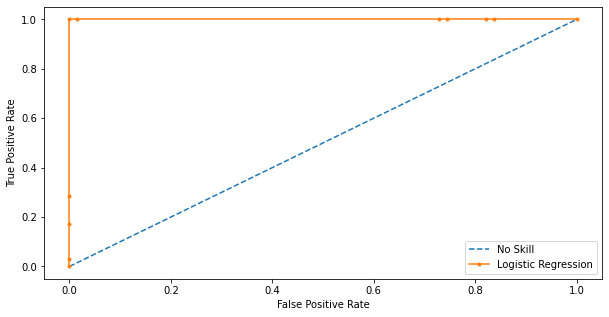

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
ax.plot(fpr, tpr, marker='.', label='Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.legend()